## SKOLTECH, Experimental Data Processing

## Evgenii Safronov, Mikhail Kurenkov, Taras Melnik

In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from numpy.linalg import inv
import matplotlib as mplb
from matplotlib.font_manager import FontProperties
%matplotlib inline
from numpy.random import normal
from mpl_toolkits.mplot3d import Axes3D
mplb.rc('xtick', labelsize=5) 
mplb.rc('ytick', labelsize=5) 

In [78]:
def kalman(X_0, P_0, z, T, h, R, Q, dh):
    X = np.zeros((len(z),*(X_0.shape)))
    P = np.zeros((len(z),*(P_0.shape)))
    K = np.zeros((len(z), X_0.shape[0], z.shape[1]))
    XF= np.zeros_like(X)
    Xp= np.zeros_like(X)
    for i, _ in enumerate(z):
        #Prediction
        Xp[i] = X[i] = T.dot(X[i-1] if i > 0 else X_0)
        P[i] = T.dot((P[i-1] if i > 0 else P_0).dot(T.transpose())) + Q
        #Filtration
        #tmp1 = inv(H.dot(P[i].dot(H.transpose())) + R[i])
        #tmp2 = H.transpose().dot(tmp1)
        #K[i] = P[i].dot(tmp2)
        tmp1 = inv(dh(Xp[i]).dot(P[i].dot(dh(Xp[i]).transpose())) + R)
        tmp2 = dh(Xp[i]).transpose().dot(tmp1)
        K[i] = P[i].dot(tmp2)
        X[i] = Xp[i] + K[i].dot(z[i] - h(Xp[i]))

        P[i] = (np.identity(X_0.shape[0]) - K[i].dot(dh(Xp[i]))).dot(P[i])
    return X, K, P, Xp

def generate_acc_trajectory(sigma_a_2, sigma_n_2, N, x_0, v_0, t, a_bias = 0):
    if sigma_a_2 == 0:
        a = np.zeros(N) + a_bias
    else:    
        a = np.random.normal(0, sigma_a_2 ** 0.5, N) + a_bias
    v = np.ones(N) * v_0
    x = np.ones(N) * x_0
    for i, a_i in enumerate(a[:-1]):
        v[i+1] = v[i] + a_i*t
    dx = (v * t + a * t * t / 2)
    for i, dx_i in enumerate(dx[:-1]):
        x[i+1] = x[i] + dx_i
    #v2 = np.ones(N) * v_0 + a.dot(np.triu(np.ones((N, N)), 1)) * t
    #x2 = np.ones(N) * x_0 + (v2 * t + a * t * t / 2).dot(np.triu(np.ones((N, N)), 1))
    z = x + np.random.normal(0, sigma_n_2 ** 0.5, N)
    return x, z

def convert_to_polar(X):
    x = X[:,0,0]
    y = X[:,2,0]
    D = (x**2 + y**2) ** 0.5
    b = np.arctan(x / y)
    return b, D

# Generate a true trajectory

In [5]:
N = 500
t = 1
x_0 = 1000
y_0 = 1000
sigma_a_2 = 0.3 ** 2
v_x = 10
v_y = 10

x, _ = generate_acc_trajectory(sigma_a_2, 1, N, x_0, v_x, t)
y, _ = generate_acc_trajectory(sigma_a_2, 1, N, y_0, v_y, t)

# Generate also true values of range $D$ and azimut $\beta$

In [6]:
D = (x**2 + y**2) ** 0.5
b = np.arctan(x / y)

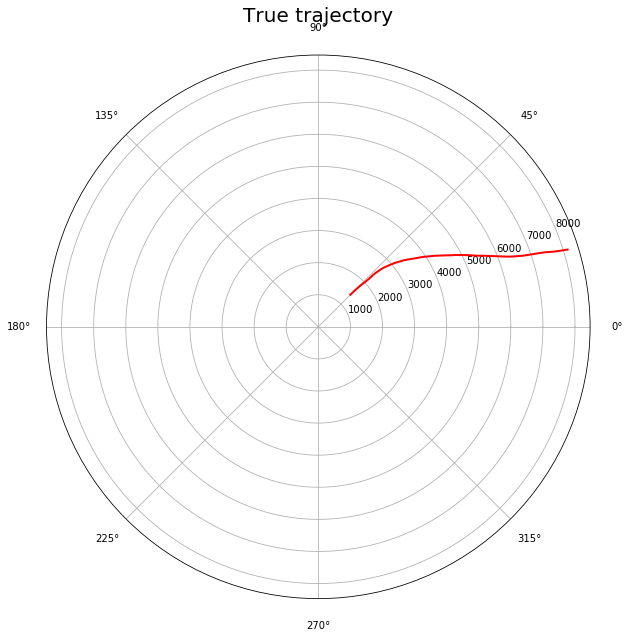

In [93]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)
ax.set_title('True trajectory', fontsize = 20)
ax.plot(b, D, 'r', linewidth=2)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)

# Generate measurements $D^m$ and $\beta^m$

In [60]:
sigma_D = 50
sigma_b = 0.004
D_n = np.random.normal(0, sigma_D, N)
b_n = np.random.normal(0, sigma_b, N)
D_m = D + D_n
b_m = b + b_n
z = np.zeros((N, 2, 1))
z[:, 0, 0] = D_m
z[:, 1, 0] = b_m

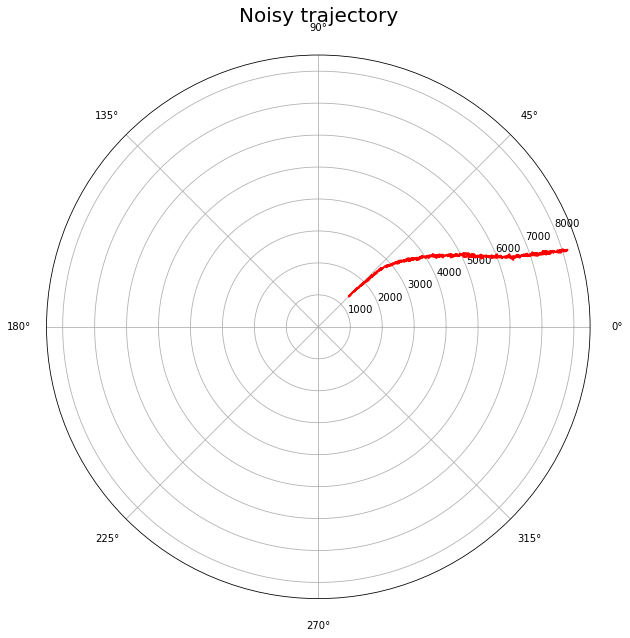

In [92]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)
ax.set_title('Noisy trajectory', fontsize = 20)
ax.plot(b_m, D_m, 'r', linewidth=2)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)

# Initial conditions for Kalman filter algorithm

In [12]:
X_0 = np.array([[D_m[0] * np.sin(b_m[0])], [0], [D_m[0] * np.cos(b_m[0])], [0]])
P_0 = np.eye(4) * 10 ** 10

# Create the transition matrix $Φ$ 

In [28]:
T = np.zeros((4, 4))
T[0:2, 0:2] = np.array([[1, t], [0, 1]])
T[2:4, 2:4] = np.array([[1, t], [0, 1]])

# Calculate state noise covariance matrix $Q$

In [27]:
G = np.zeros((4, 2)) 
G[0:2, 0:1] = np.array([[t ** 2 / 2], [t]])
G[2:4, 1:2] = np.array([[t ** 2 / 2], [t]])
Q = G.dot(G.transpose() * sigma_a_2)

# Create the measurement noise covariance matrix $R$

In [74]:
R = np.array([[sigma_D ** 2, 0], [0, sigma_b ** 2]])

# linearize measurement equation 

In [75]:
def h(X):
    x = X[0]
    y = X[2]
    H = np.zeros((2, 1))
    H[0] = (x ** 2 + y ** 2) ** 0.5
    H[1] = np.arctan(x / y)
    return H

def dh(X):
    x = X[0, 0]
    y = X[2, 0]
    dH = np.zeros((2, 4))
    dH[0, 0] = x / (x ** 2 + y ** 2) ** 0.5
    dH[0, 2] = y / (x ** 2 + y ** 2) ** 0.5
    dH[1, 0] = y / (x ** 2 + y ** 2)
    dH[1, 2] = - x / (x ** 2 + y ** 2)
    return dH

# Develop Kalman filter algorithm 

In [90]:
X, K, _, Xp = kalman(X_0, P_0, z, T, h, R, Q, dh)

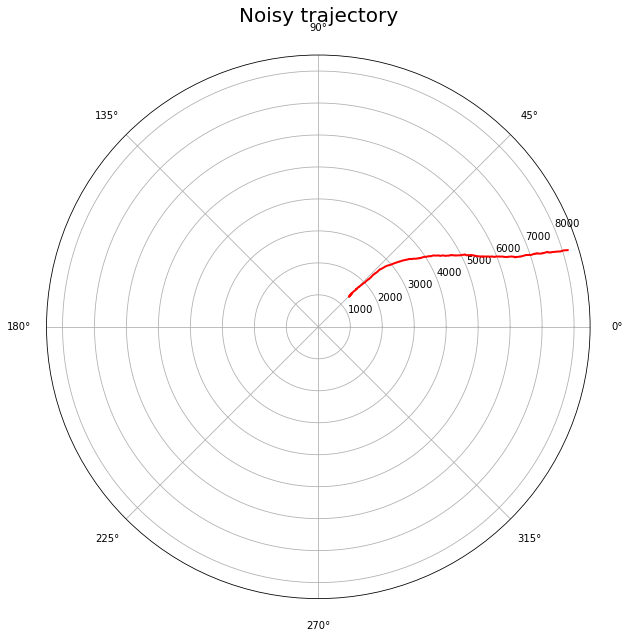

In [91]:
b_f, D_f = convert_to_polar(Xp)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)
ax.set_title('Noisy trajectory', fontsize = 20)
ax.plot(b_f, D_f, 'r', linewidth=2)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)

# Run Kalman filter algorithm over $M=500$ runs

In [99]:
M = 500
N = 500
t = 1
x_0 = 1000
y_0 = 1000
sigma_a_2 = 0.3 ** 2
v_x = 10
v_y = 10
sigma_D = 50
sigma_b = 0.004

error_b_f = np.zeros((N, M))
error_D_f = np.zeros((N, M))
error_b_p = np.zeros((N, M))
error_D_p = np.zeros((N, M))

for i in range(M):
    x, _ = generate_acc_trajectory(sigma_a_2, 1, N, x_0, v_x, t)
    y, _ = generate_acc_trajectory(sigma_a_2, 1, N, y_0, v_y, t)

    D = (x**2 + y**2) ** 0.5
    b = np.arctan(x / y)
    D_n = np.random.normal(0, sigma_D, N)
    b_n = np.random.normal(0, sigma_b, N)
    D_m = D + D_n
    b_m = b + b_n
    z = np.zeros((N, 2, 1))
    z[:, 0, 0] = D_m
    z[:, 1, 0] = b_m
    
    X_0 = np.array([[D_m[0] * np.sin(b_m[0])], [0], [D_m[0] * np.cos(b_m[0])], [0]])
    P_0 = np.eye(4) * 10 ** 10
    
    X, K, _, Xp = kalman(X_0, P_0, z, T, h, R, Q, dh)
    
    b_f, D_f = convert_to_polar(X)
    b_p, D_p = convert_to_polar(Xp)
    
    error_b_f[:,i] = (b - b_f) ** 2
    error_D_f[:,i] = (D - D_f) ** 2
    error_b_p[:,i] = (b - b_p) ** 2
    error_D_p[:,i] = (D - D_p) ** 2

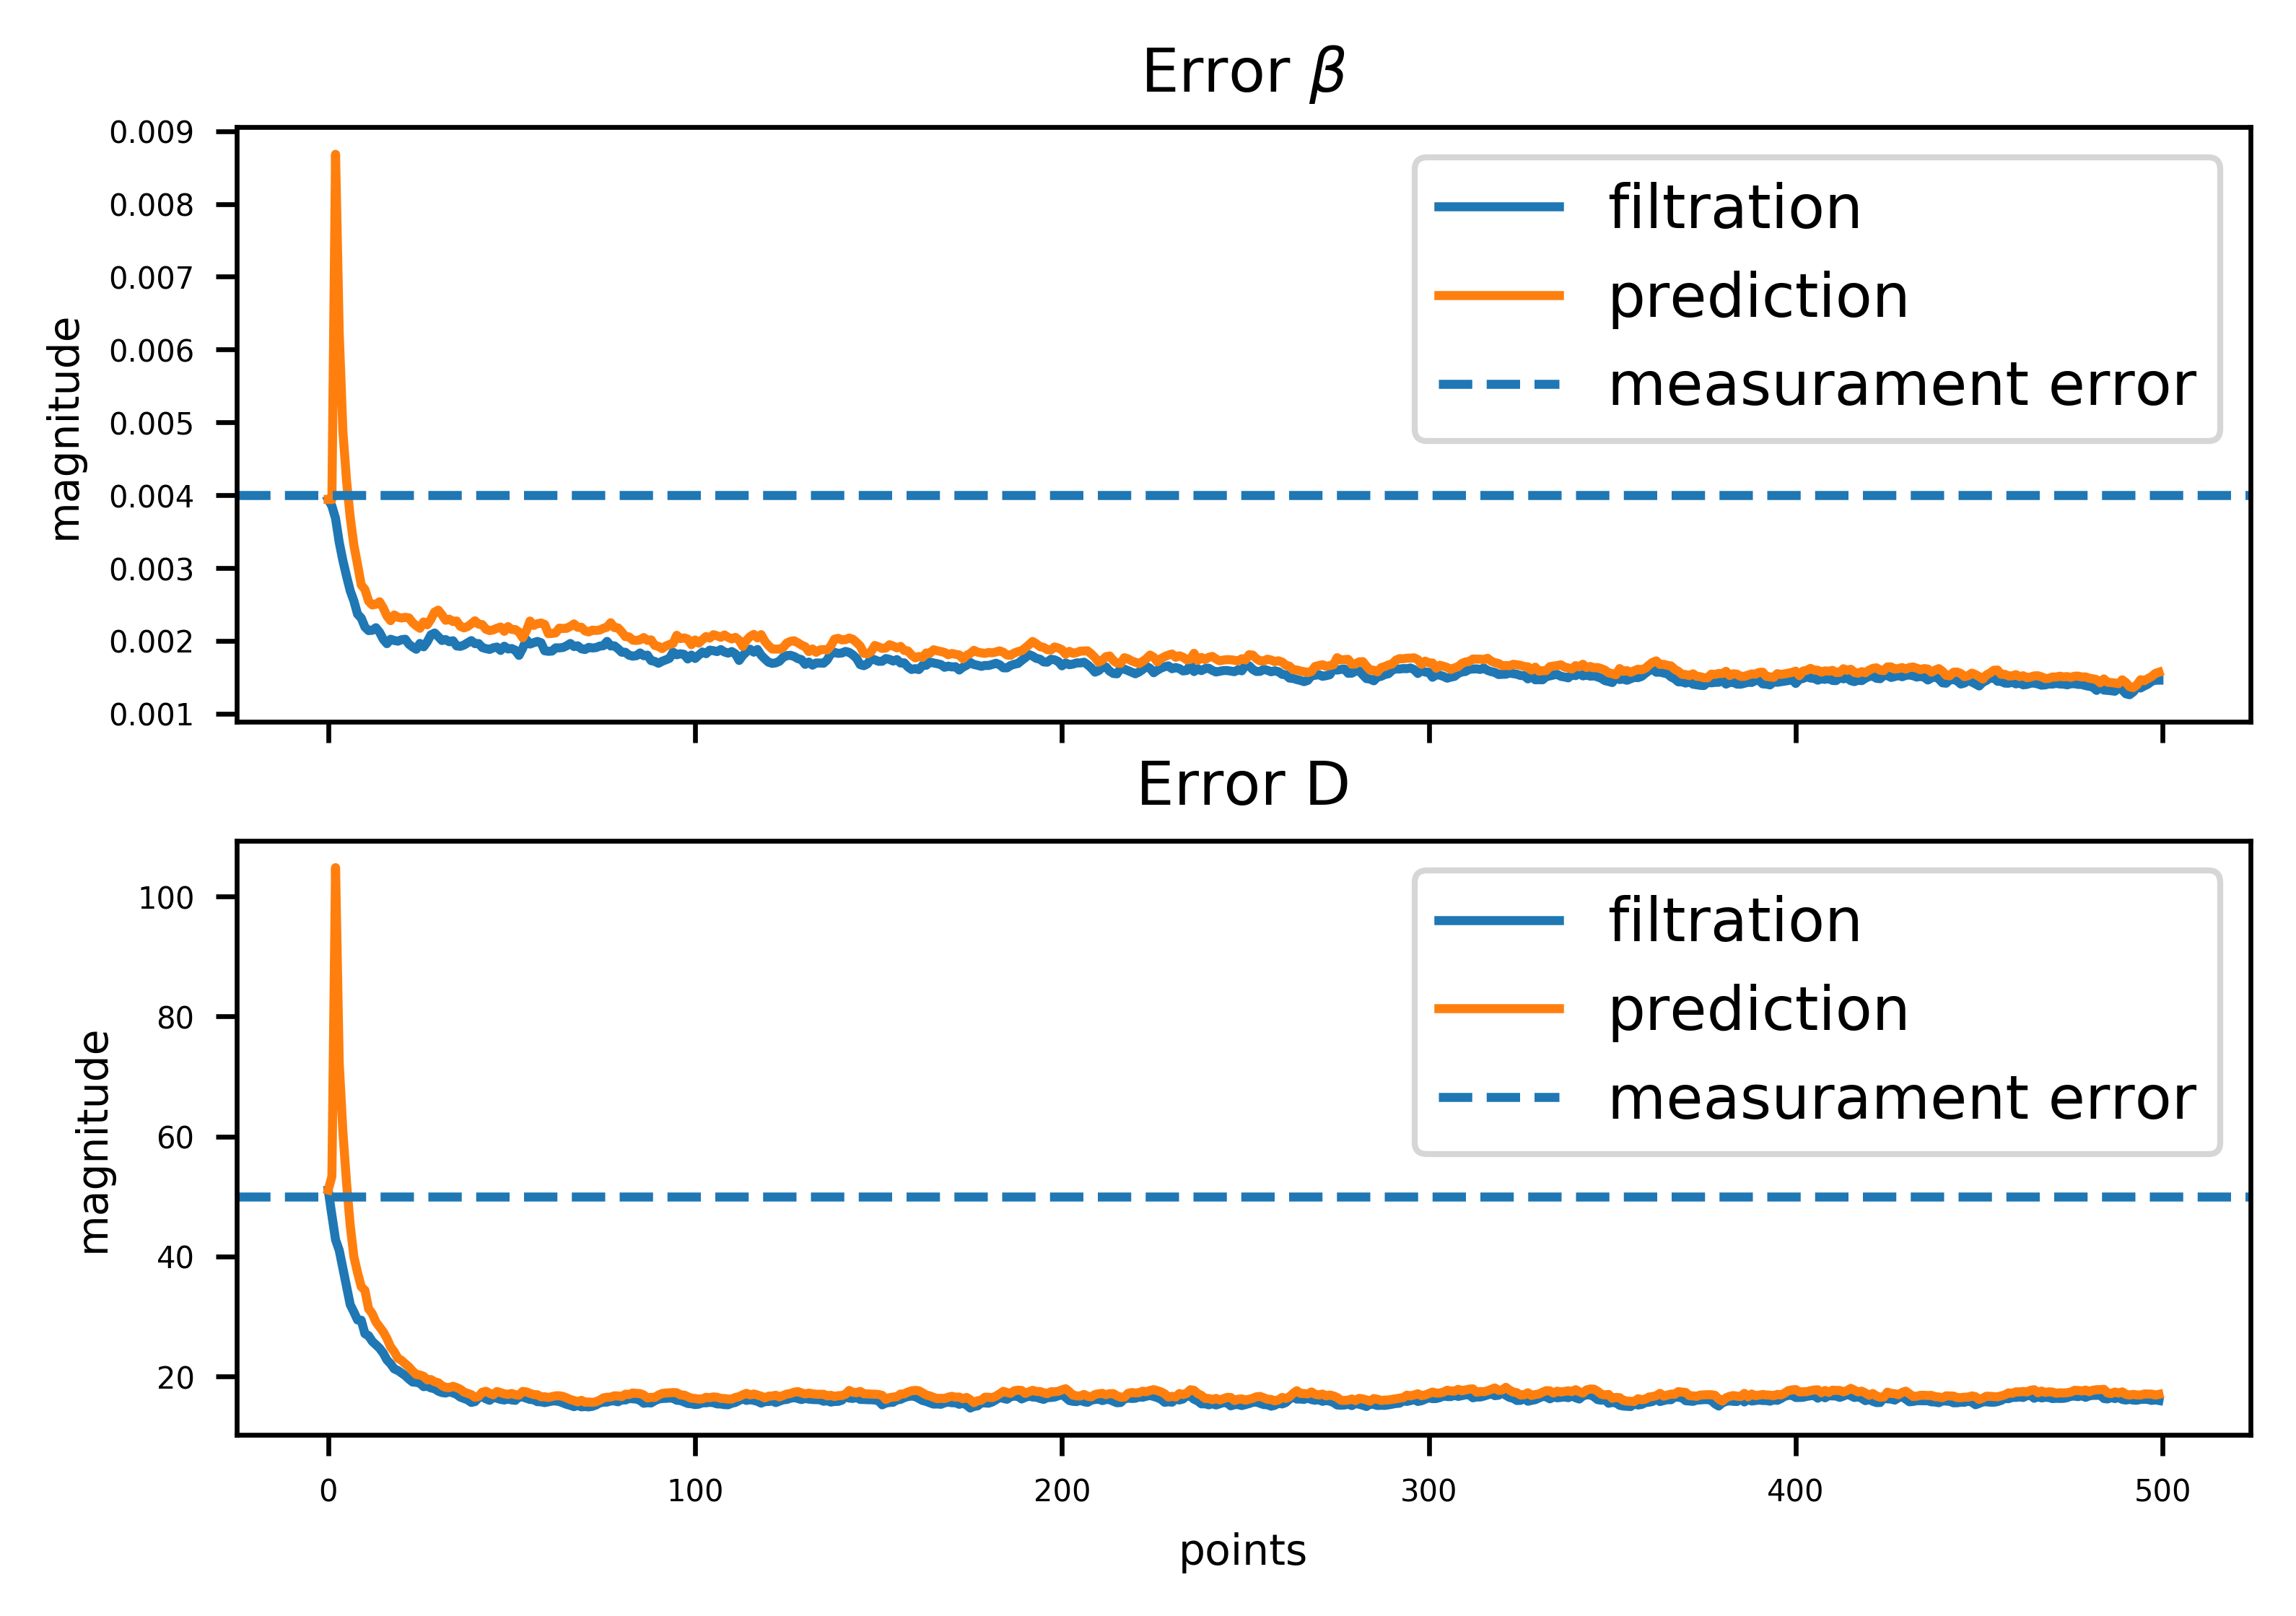

In [109]:
fig, ax = plt.subplots(2,1, figsize=(6,4), dpi = 600, sharex = True)
ax[0].set_title(r'Error $\beta$', fontsize = 10)
ax[0].plot( (np.sum(error_b_f,axis=1)/(M-1))**0.5, label = 'filtration')
ax[0].plot( (np.sum(error_b_p,axis=1)/(M-1))**0.5,  label = 'prediction')
ax[0].set_ylabel('magnitude', fontsize = 7)
ax[0].axhline(sigma_b, label = "measurament error", linestyle='--')
ax[0].legend(loc='upper right')

ax[1].set_title('Error D', fontsize = 10)
ax[1].plot( (np.sum(error_D_f,axis=1)/(M-1))**0.5, label = 'filtration')
ax[1].plot( (np.sum(error_D_p,axis=1)/(M-1))**0.5,  label = 'prediction')
ax[1].set_xlabel('points', fontsize = 7)
ax[1].set_ylabel('magnitude', fontsize = 7)
ax[1].axhline(sigma_D, label = "measurament error", linestyle='--')
ax[1].legend(loc='upper right');

## One can see from this plot that measurement error is times higher than true estimaiton error of filtration and prediction

# Conclusion

## Today we have learned extended Kalman filter